This notebook is duplicated from "Thesis_fixed_time_data_full" with the only difference that we take only the top 5 importants features.

# Imports

In [4]:
import pandas as pd
import psycopg2

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from plot_classification_report import plot_classification_report

# Read Data Set

In [5]:
df = pd.read_csv("mergeData_fixed_time.csv")
df = df.drop('total_time', axis=1) 
df.head()

,pedId,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,...,gender,age,job,LatestDegree,oftenDrive,accidents,yearsDriving,lastDrive(years),speedingTickets,hadCollision
0,1.0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,...,0,32,0,0,2,0,10,1.0,0,0
1,3.0,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,...,0,32,0,0,2,0,10,1.0,0,0
2,15.0,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,...,0,32,0,0,2,0,10,1.0,0,1
3,2.0,11.669419,0.500661,0.891913,0.522365,0.008028,47.209285,0.000396,0.055982,0.112551,...,0,32,0,0,2,0,10,1.0,0,0
4,4.0,12.187044,0.499769,0.861132,0.558120,0.001881,42.031423,0.000430,0.102442,0.079023,...,0,32,0,0,2,0,10,1.0,0,0


### Understanding features

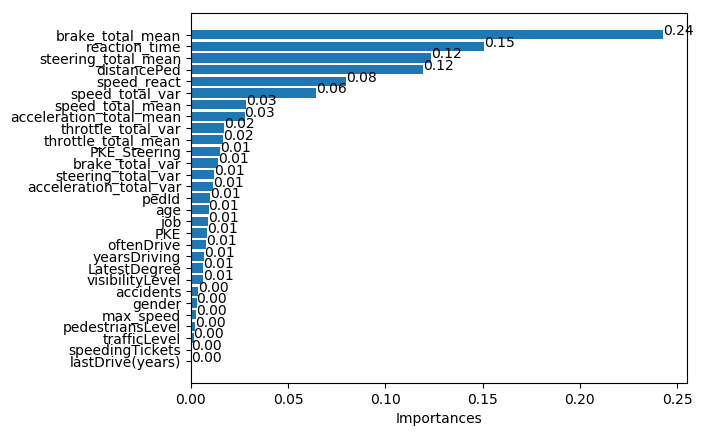

In [31]:
from sklearn.tree import DecisionTreeClassifier


def feature_importance_plot(data, repeat=1000, class_weight=None):
    X = data.drop('hadCollision', axis=1) 
    Y = data['hadCollision']
    result = []
    
    for i in range(1, repeat):
        classifier = DecisionTreeClassifier(class_weight=class_weight)
        classifier.fit(X, Y)
        result.append(classifier.feature_importances_)
    
    importances = [sum(x)/repeat for x in zip(*result)]
    
    plot_importance(X.columns, importances)
    
def plot_importance(x_columns, feature_importances):
    importances_zip = zip(x_columns, feature_importances)
    importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
    columns = []
    importances = []
    for name, importance in importances_sorted:
        columns.append(name)
        importances.append(importance)

    plt.rcdefaults()
    fig, ax = plt.subplots()

    ax.barh(columns, importances, align='center')
    for index,value in enumerate(importances):
        ax.text(value, index, str("{:.2f}".format(value)))

    ax.set_yticks(x_columns)
    ax.set_yticklabels(x_columns)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importances')

    plt.show()

data = df.copy()

feature_importance_plot(data)

### Adding class_weight

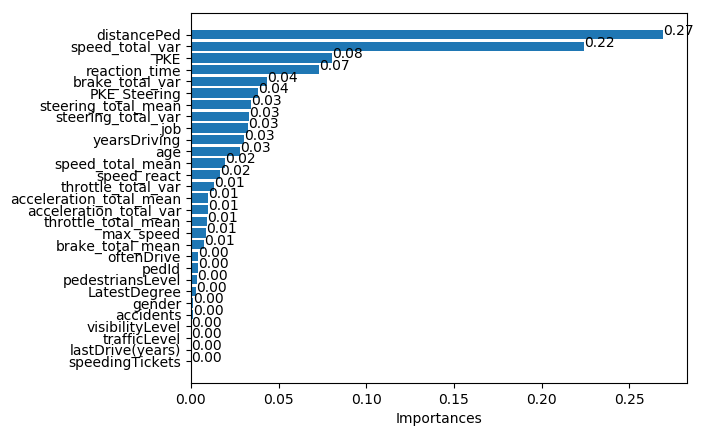

In [32]:
feature_importance_plot(data, 1000, {0:10, 1:1})

In [33]:
data = data[['brake_total_mean','reaction_time', 'steering_total_mean','distancePed', 'speed_react', 'speed_total_var','PKE', 'hadCollision']]

In [34]:
data.head()

,brake_total_mean,reaction_time,steering_total_mean,distancePed,speed_react,speed_total_var,PKE,hadCollision
0,0.947244,1.048791,0.493644,68.920520,7.754880,13.607109,1.110623,0
1,0.875541,2.106615,0.504890,69.359540,13.472353,33.663919,0.084626,0
2,0.817679,0.079211,0.478319,96.885284,25.585112,76.873997,5.246326,1
3,0.891913,1.161592,0.500661,88.011610,19.412087,47.209285,2.969647,0
4,0.861132,1.275896,0.499769,105.973686,18.461056,42.031423,4.033468,0


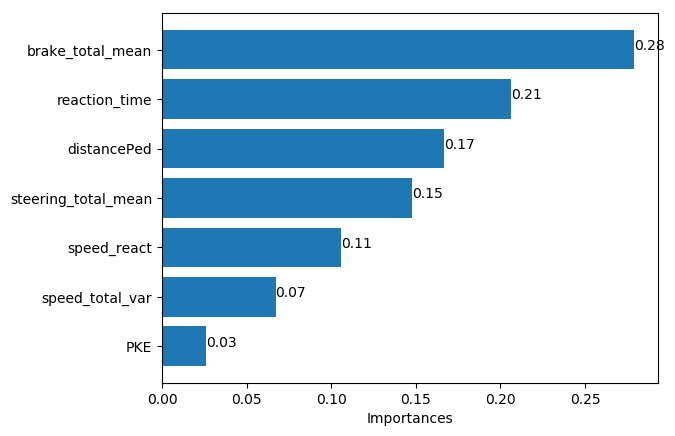

In [35]:
feature_importance_plot(data)

Importances has change now, having distancePed in first place.

### Context

The data source is created from "thesis_molding_fixed_time.ipynb" from the initial data set of GTA, Driving simulator and demographic data.

&nbsp; Each row cames from every pedestrian that driver cross. So we have many rows for every scenario (depending on how many pedestrians where in that scenario) and many scenarios from every driver (there are 5 scenarios). 
    
&nbsp; We took a previous fixed period of time of every pedestrian (taking a tail of rows from the initial data set of every pedestrian identified) and having as the target feature the result of the collision between the car and the pedestrian.

The columns in this merged data are:
- **brake_total_mean**: mean from brake pedal from Driving simulator in that period of time
- **total_time**: time in seconds of that period of time (can be different because some pedestrians appear quickly or some drivers where stopped on a traffic light).
- **distancePed**: initial distance between the driver and the pedestrian
- **PKE**: Agressive driving measure considering drastic movements of speed 
- **reaction_time**: time in seconds from when the pedestrian started running until there was a reaction in the driver's brake pedal
- **hadCollision**: False: 0, True: 1
    

### Distribution of cases

In [36]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  37 (7.60%)
Number of False cases: 450 (92.40%)


We have considerably more false cases than true ones.

## Split data set

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=1, stratify=Y)

In [38]:
def print_split_data_set(X_train, X_test, y_train, y_test):
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))
    
print_split_data_set(X_train, X_test, y_train, y_test)

Training True  : 22 (7.53%)
Training False : 270 (92.47%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Normally I divide the data in 60% for training and 40% for test, having as target the column 'hadCollision'. I choose this percentages due to having a poor number of true cases. However I will try different combinations to see which has better results.

# Predictions

First I will start with the DecisionTree that made the feature importances plot.

### Auxiliar function for random repeats

In [39]:
def default_train_test_split(test_size):
    return train_test_split(X, Y, test_size=test_size, stratify=Y)

def repite_model_predict_algorithm( fit_function, predict_function, repetitions=50, test_size=0.4, split_fuction=default_train_test_split):
    y_pred_total = []
    y_test_total = []
    for i in range(repetitions):
        X_train, X_test, y_train, y_test = split_fuction(test_size)
        fit_function(X_train, y_train)
        y_pred = predict_function(X_test)
        y_pred_total.append(y_pred)
        y_test_total.append(y_test)
    
    y_test_total = [val for sublist in y_test_total for val in sublist]
    y_pred_total = [val for sublist in y_pred_total for val in sublist]
    lookup = {0: 'No Hit', 1:'Yes Hit'}
    y_true_pd = pd.Series([lookup[_] for _ in y_test_total])
    y_pred_pd = pd.Series([lookup[_] for _ in y_pred_total])
    
    summarize_results(y_true_pd, y_pred_pd)

    
def summarize_results(y_true_pd, y_pred_pd):
    print("Total Accuracy: %{0:.2f}".format(accuracy_score(y_true_pd, y_pred_pd)*100))
    print("")
    print("Confusion Matrix")
    print("")
    tab = pd.crosstab(y_true_pd, y_pred_pd, rownames=['True'], colnames=['Predicted'], margins=False)

    print(tab)
    print("")    
    plot_confusion_matrix(metrics.confusion_matrix(y_true_pd, y_pred_pd))

    #print("Classification Report")
    print("")
    cr = metrics.classification_report(y_true_pd, y_pred_pd)
    #print(cr)
    plot_classification_report(cr)

In [40]:
def plot_confusion_matrix(matrix):

    ax1 = pie_plot(1, 'No Hits predictions', matrix[0], ['g','r'], ['No Hit', 'Hit'])
    ax2 = pie_plot(2, 'Hits predictions recall', [matrix[1][1], matrix[1][0]], ['g','r'], ['Hit', 'No Hit'])

    plt.show()
    
def pie_plot(i, title, sizes, colors, labels):
    ax1 = plt.subplot(2,2,i)

    ax1.set_title(title)
    ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    
    ax1.axis('equal')
    return ax1

## Decision Tree

Total Accuracy: %91.32

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     171462     8538
Yes Hit      8392     6608



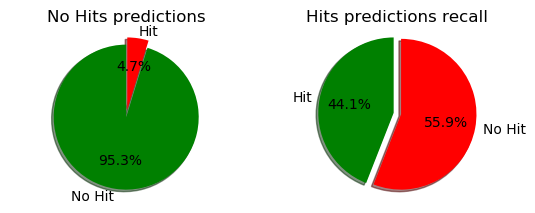

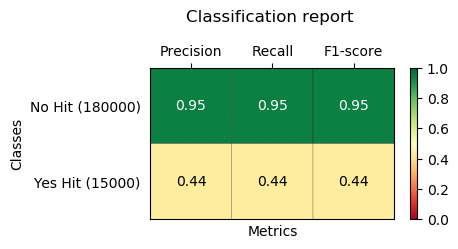

In [41]:
from sklearn.metrics import accuracy_score 
from sklearn import tree

clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

We can see a slight improvement comparing with full data, having in every component more than 50% of assertions.

## KNN classifier

### Search for best n neighbors number

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 4}

### KNN classifier with n=4

Total Accuracy: %93.88

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      90625      375
Yes Hit      5618     1382



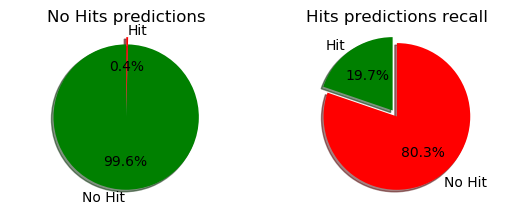

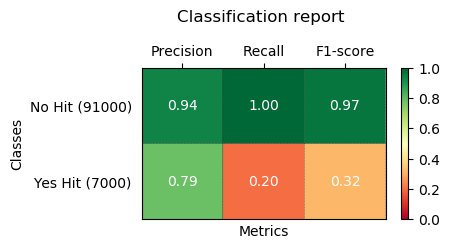

In [43]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2)

This case is similar to full data

## Random Forest

Total Accuracy: %93.19

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     134172     1828
Yes Hit      8180     2820



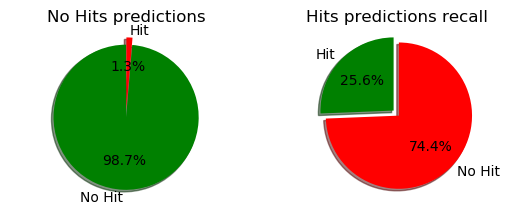

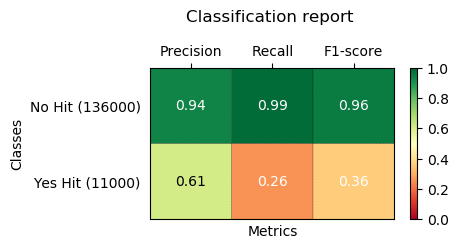

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

We can see here again a slight improvement comparing with full data, having a good precision and a F1-score more than 50%.

# Over sampling data

Now we will try increasing the numbers of true cases with different over sampling approachs:

## Random Over Sampler

In [45]:
from imblearn.over_sampling import RandomOverSampler

def random_over_sampler_split(test_size):
    ros = RandomOverSampler()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

def print_over_sampling_fuction(split_function, test_size):
    X_resampled, X_test, y_resampled, y_test = split_function(test_size)
    print_split_data_set(X_resampled, X_test, y_resampled, y_test)

In [46]:
print_over_sampling_fuction(random_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


Here we can see that False cases were splitted normally and "Training True" cases are now equals to falses.

### Decision Tree

This algorith was ignore because results were worst than before (without over sampling data)

### KNN classifier

Total Accuracy: %88.08

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      83055     7945
Yes Hit      3734     3266



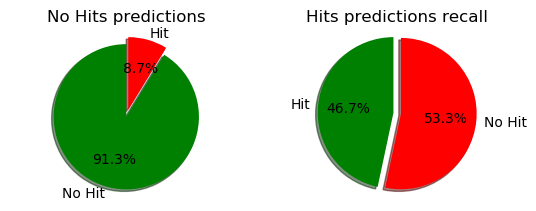

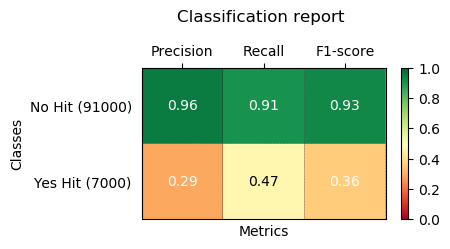

In [47]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, random_over_sampler_split)

This case is worst than with full data

### Random Forest

Total Accuracy: %93.01

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     177986     2014
Yes Hit     11617     3383



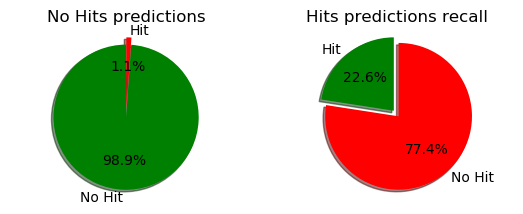

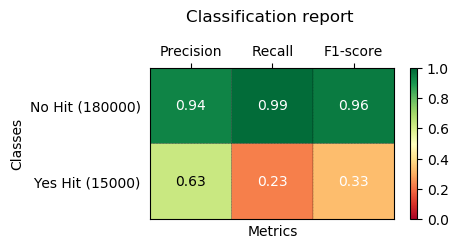

In [48]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

We can see a little better recall for Hits predictions, always comparing full data.

## SMOTE

In [49]:
from imblearn.over_sampling import SMOTE, ADASYN

def smote_over_sampler_split(test_size):
    smote = SMOTE()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = smote.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(smote_over_sampler_split, 0.4)

Training True  : 270 (50.00%)
Training False : 270 (50.00%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


### Decision Tree

Total Accuracy: %87.13

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     164235    15765
Yes Hit      9335     5665



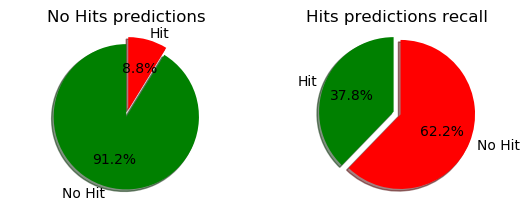

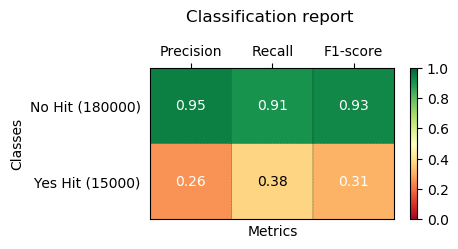

In [50]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

Slight improvement

### KNN classifier

Total Accuracy: %83.99

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      78728    12272
Yes Hit      3413     3587



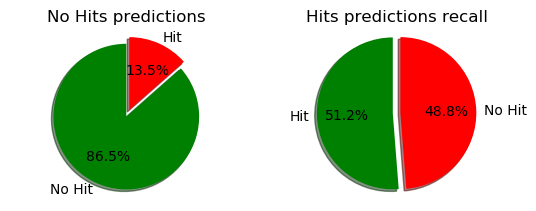

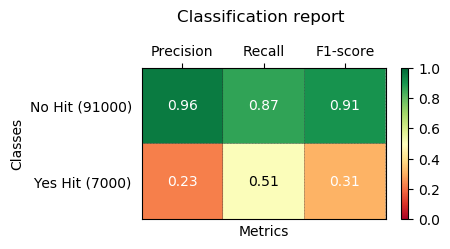

In [51]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.2, smote_over_sampler_split)

Similar to full data case.

### Random Forest

Total Accuracy: %91.92

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     131853     4147
Yes Hit      7725     3275



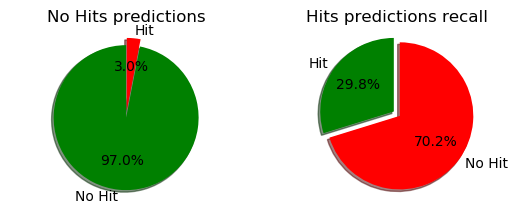

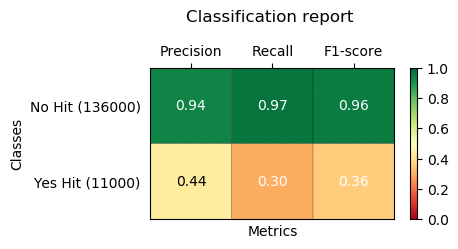

In [52]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

Slight improvement

## ADASYN

In [53]:
def adasyn_over_sampler_split(test_size):
    adasyn = ADASYN()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, stratify=Y)
    X_resampled, y_resampled = adasyn.fit_sample(X_train, y_train)
    return X_resampled, X_test, y_resampled, y_test

print_over_sampling_fuction(adasyn_over_sampler_split, 0.4)

Training True  : 269 (49.91%)
Training False : 270 (50.09%)

Test True      : 15 (7.69%)
Test False     : 180 (92.31%)


This oversampling it's not totally exactly when doing the true training cases. So it's not exactly 50% of each.

### Decision Tree

Ignored

### KNN classifier

Total Accuracy: %74.88

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     137708    42292
Yes Hit      6701     8299



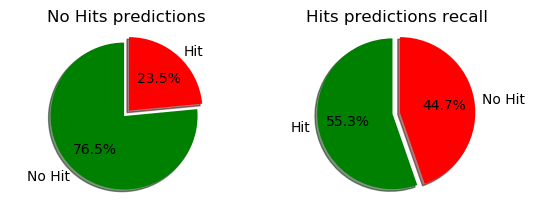

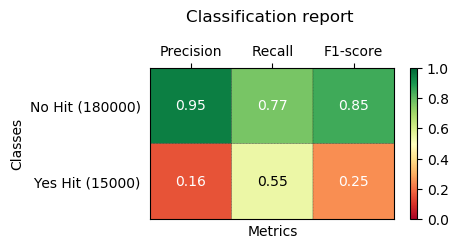

In [54]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

Similar recall to Smote but worst precision. Similar to full data case.

### Random Forest

Total Accuracy: %90.58

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     173227     6773
Yes Hit     11599     3401



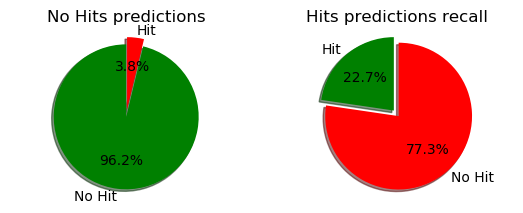

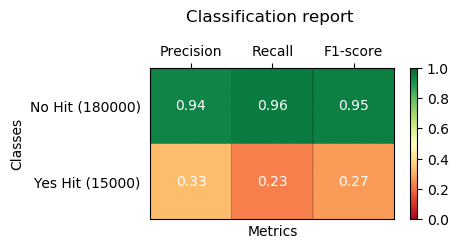

In [55]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)

Better results from full data.

# Changing training data

I will try training the data with the same numbers of false cases and true cases but this time with less false cases:

In [56]:
def equal_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives)

def double_false_cases_split(training_size_positives):
    return split_cases(training_size_positives, training_size_positives*2)

def split_cases(positive_training_size, negative_training_size):
    positives = data.loc[df['hadCollision'] == 1].copy()
    negatives = data.loc[df['hadCollision'] == 0].copy()
    test_size_pos = len(positives) - positive_training_size
    test_size_neg = len(negatives) - negative_training_size

    X_train_pos, X_test_pos = train_test_split(positives, train_size=positive_training_size, test_size=test_size_pos)
    X_train_neg, X_test_neg = train_test_split(negatives, train_size=negative_training_size, test_size=test_size_neg)
    X_train_total = X_train_pos.append(X_train_neg)
    X_test_total = X_test_pos.append(X_test_neg)

    X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
    X_test_total = X_test_total.sample(frac=1).reset_index(drop=True)
    X_train = X_train_total.drop('hadCollision', axis=1) 
    y_train = X_train_total['hadCollision']

    X_test = X_test_total.drop('hadCollision', axis=1) 
    y_test = X_test_total['hadCollision']
    return X_train, X_test, y_train, y_test

def print_results_with_size(split_function, train_size_pos):
    X_train, X_test, y_train, y_test = split_function(train_size_pos)
    print("Training True  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train) * 100.0)))
    print("Training False : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train) * 100.0)))
    print("")
    print("Test True      : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test) * 100.0)))
    print("Test False     : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test) * 100.0)))

In [57]:
print_results_with_size(equal_cases_split, 30)

Training True  : 30 (50.00%)
Training False : 30 (50.00%)

Test True      : 7 (1.64%)
Test False     : 420 (98.36%)


We have now a training set of only 60 cases with 50% hits and 50% no hits. I decided to take 30 true cases as it's almost de 80% of true cases for training.

### Decision Tree

Total Accuracy: %74.63

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     313631   106369
Yes Hit      1972     5028



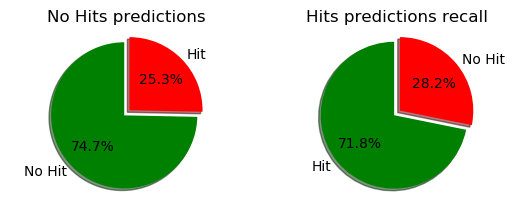

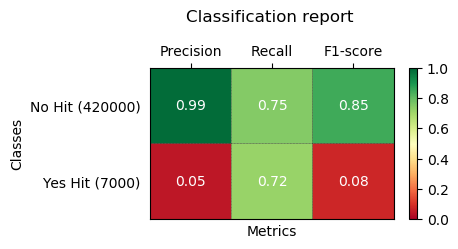

In [58]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

Similar to full data.

In [59]:
print_results_with_size(double_false_cases_split, 20)

Training True  : 20 (33.33%)
Training False : 40 (66.67%)

Test True      : 17 (3.98%)
Test False     : 410 (96.02%)


Trying with the double of false cases for training in order to get more precision of "Yes Hit" cases, but this time taking only 20 true cases for training.

Total Accuracy: %82.93

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     343285    66715
Yes Hit      6195    10805



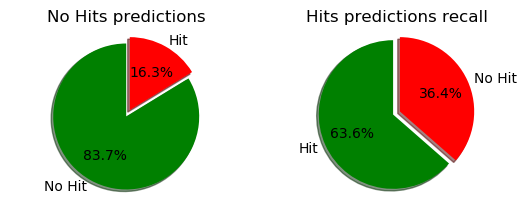

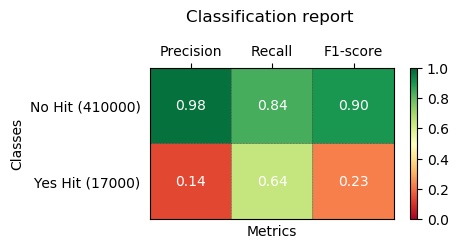

In [60]:
clf = tree.DecisionTreeClassifier()

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 20, double_false_cases_split)

Similar full data.

### Knn

Total Accuracy: %90.19

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     381684    38316
Yes Hit      3553     3447



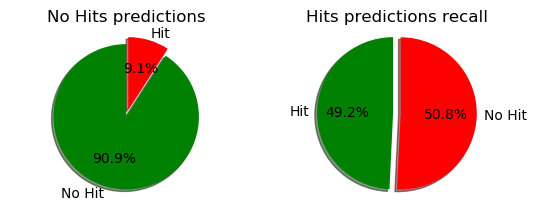

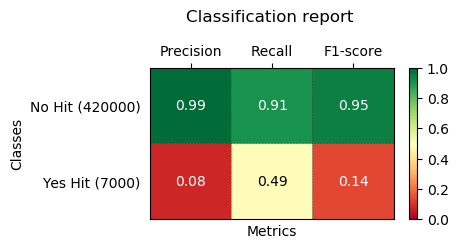

In [61]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, equal_cases_split)

Worst metrics as before

Total Accuracy: %95.48

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     376018    13982
Yes Hit      3943     3057



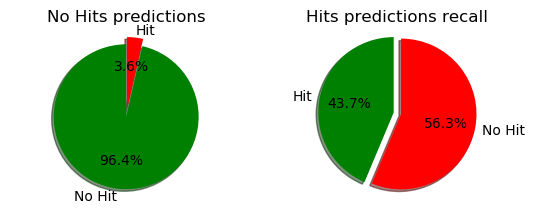

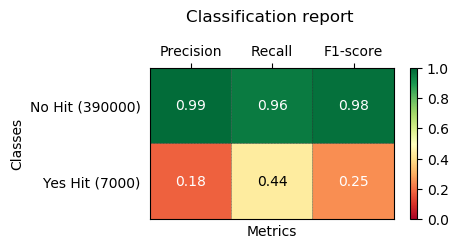

In [62]:
knn = KNeighborsClassifier(n_neighbors = 4)

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  30, double_false_cases_split)

Worst metrics than with full data.

### Random Forest

Total Accuracy: %82.99

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     349449    70551
Yes Hit      2080     4920



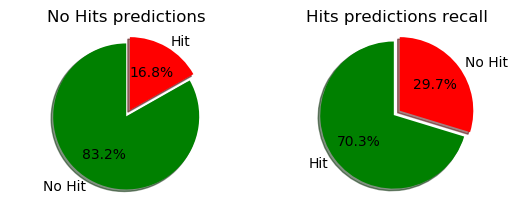

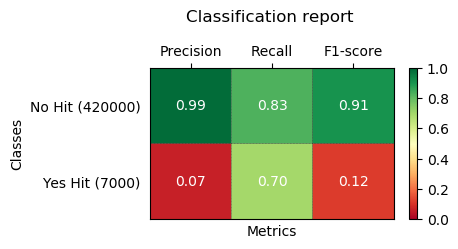

In [63]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

We have same precision but a bit more recall from before.

Total Accuracy: %90.52

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     376579    33421
Yes Hit      7038     9962



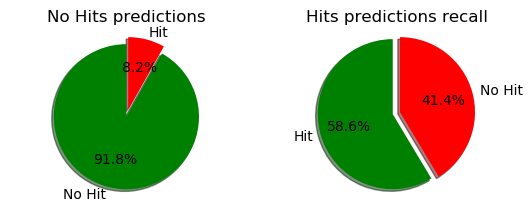

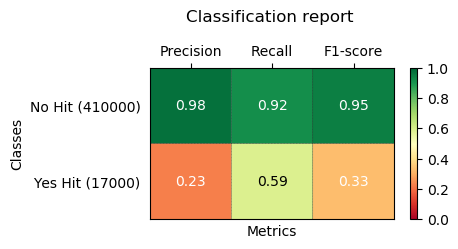

In [64]:
rf_model = RandomForestClassifier()
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 20, double_false_cases_split)

Little bit more recall than before.

# Weights classes

## Balanced

### Decision Tree

Total Accuracy: %90.14

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86246     4754
Yes Hit      4912     2088



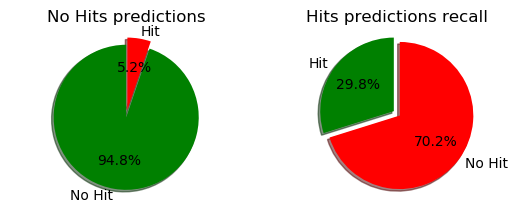

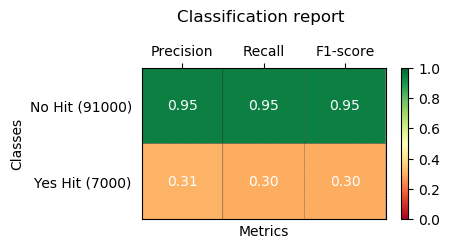

In [65]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2)

Worst than default case.

### KNN

Default value is 'uniform' or balance, so I will try with distance

Total Accuracy: %93.31

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     177916     2084
Yes Hit     10961     4039



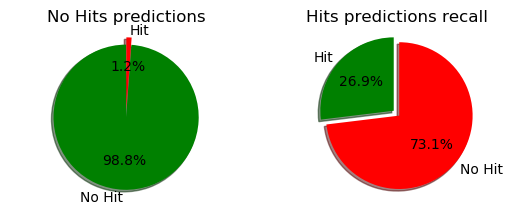

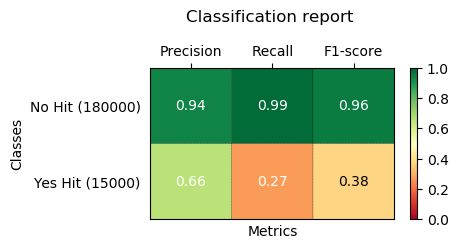

In [66]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

repite_model_predict_algorithm(knn.fit, knn.predict, 1000,  0.4)

Same overfitting as default case

### Random Forest

#### Balanced

Total Accuracy: %93.05

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135483      517
Yes Hit      9703     1297



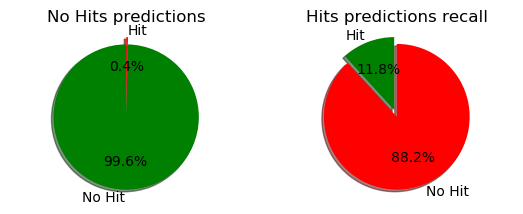

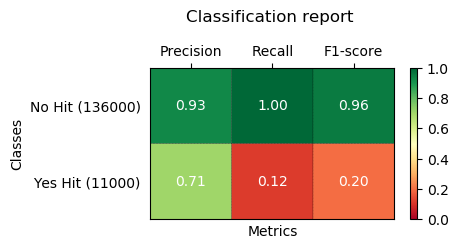

In [67]:
rf_model = RandomForestClassifier(class_weight="balanced")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default.

#### Balanced Subsample

Total Accuracy: %93.02

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     135448      552
Yes Hit      9712     1288



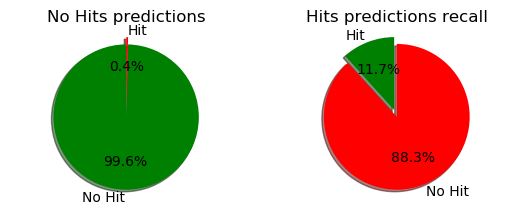

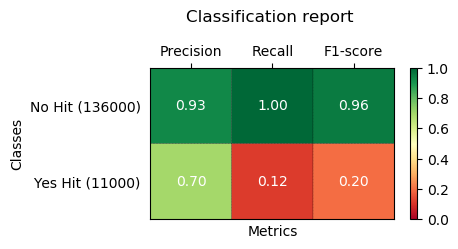

In [68]:
rf_model = RandomForestClassifier(class_weight="balanced_subsample")
repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)

Same overfitting as default

### Decision Tree

In [69]:
from IPython.core.display import display, Markdown

def print_header(header):
    raw_html = "<h3>"+header+"</h3>"
    display( Markdown(raw_html) )

<h3>Running: Default model-prediction</h3>

Total Accuracy: %91.22

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     170755     9245
Yes Hit      7871     7129



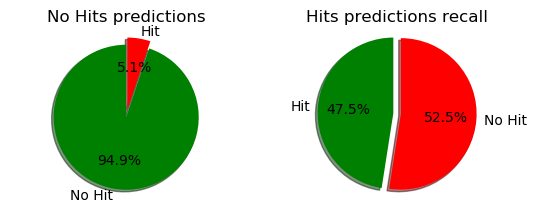

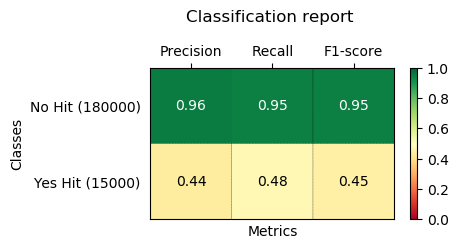

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %91.33

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit      86453     4547
Yes Hit      3948     3052



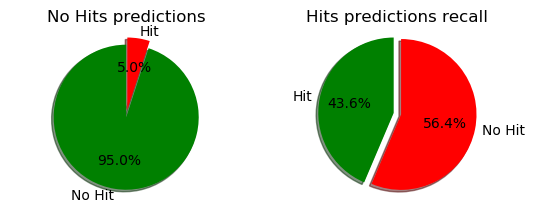

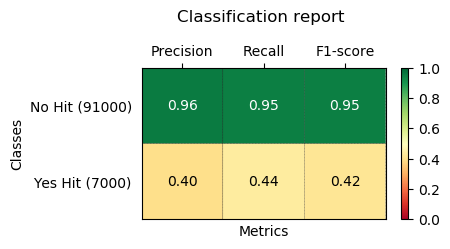

<h3>Running: SMOTE</h3>

Total Accuracy: %87.74

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     162363    17637
Yes Hit      6274     8726



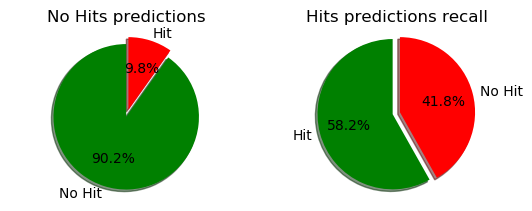

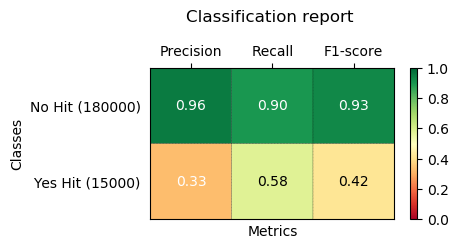

<h3>Running: ADASYN</h3>

Total Accuracy: %69.82

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     127178    52822
Yes Hit      6020     8980



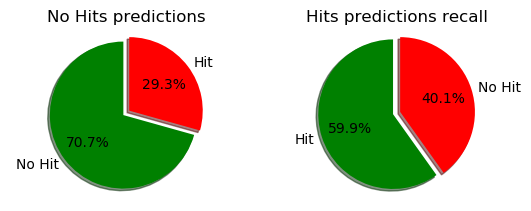

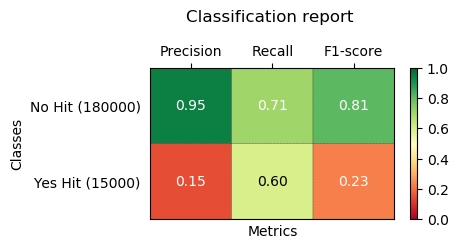

<h3>Running: Equal training cases</h3>

Total Accuracy: %75.84

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     318459   101541
Yes Hit      1619     5381



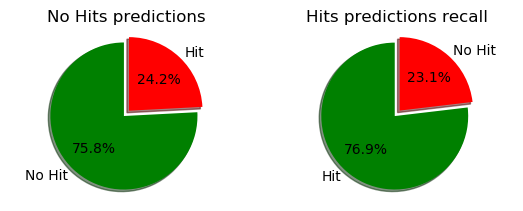

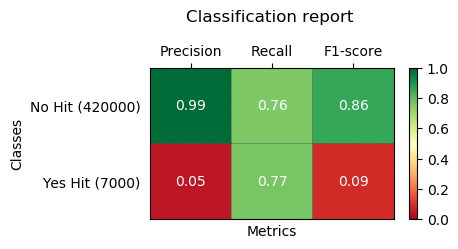

<h3>Running: Double false training cases</h3>

Total Accuracy: %83.72

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     327312    62688
Yes Hit      1949     5051



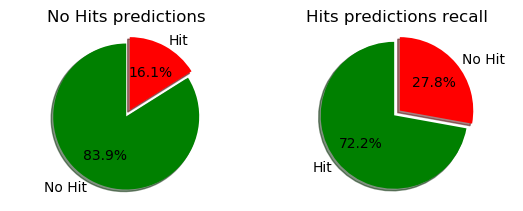

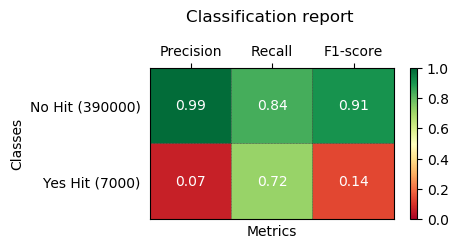

In [70]:
def run_all_models(clf):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4)

    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.2, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 0.4, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(knn.fit, knn.predict, 1000, 0.4, adasyn_over_sampler_split)

    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(clf.fit, clf.predict, 1000, 30, double_false_cases_split)
    
clf = tree.DecisionTreeClassifier(class_weight={0:10, 1:1})
run_all_models(clf)

Again we can see a slight improvement but similar cases as with full data. So we can say is better with less data in this case.

### Knn

I didn't find Knn class_weigths, it has a function weigth but I think is only weigths per feature:
    
    - [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

### Random Forest

<h3>Running: Default model-prediction</h3>

Total Accuracy: %93.10

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     133284     2716
Yes Hit      7421     3579



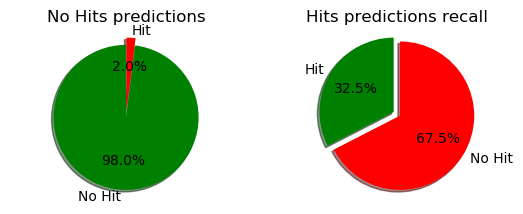

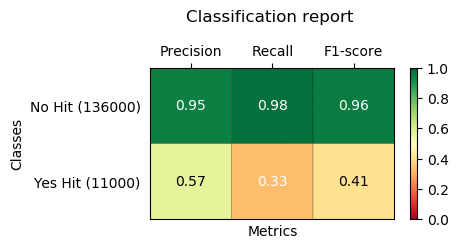

<h3>Running: Random Over Sampler</h3>

Total Accuracy: %93.21

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     175732     4268
Yes Hit      8970     6030



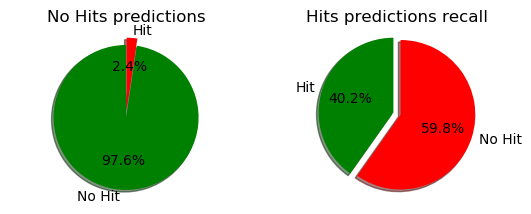

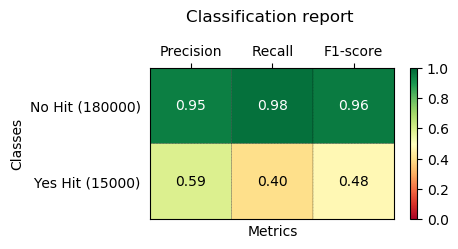

<h3>Running: SMOTE</h3>

Total Accuracy: %91.57

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     128182     7818
Yes Hit      4570     6430



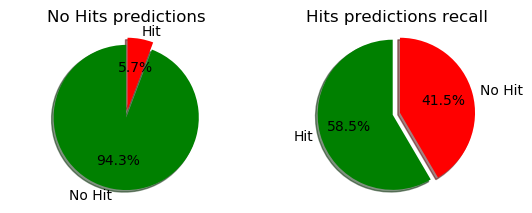

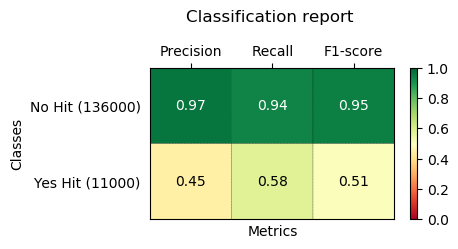

<h3>Running: ADASYN</h3>

Total Accuracy: %89.25

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     165258    14742
Yes Hit      6213     8787



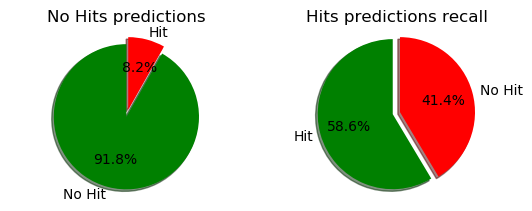

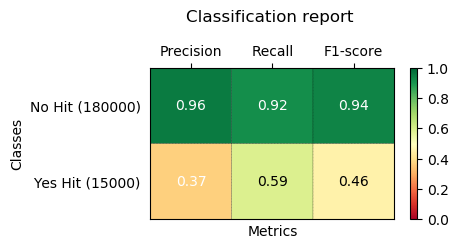

<h3>Running: Equal training cases</h3>

Total Accuracy: %82.57

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     347312    72688
Yes Hit      1723     5277



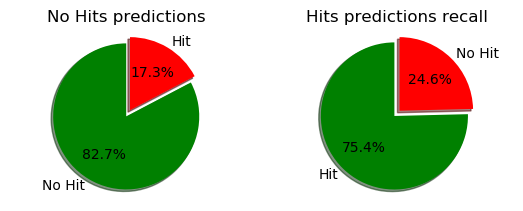

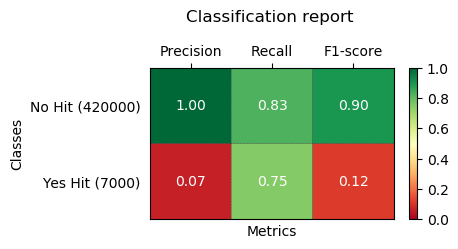

<h3>Running: Double false training cases</h3>

Total Accuracy: %90.82

Confusion Matrix

Predicted  No Hit  Yes Hit
True                      
No Hit     355795    34205
Yes Hit      2243     4757



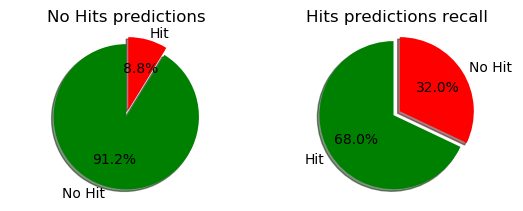

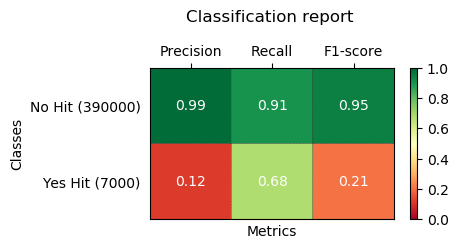

In [71]:
def run_all_models(rf_model):
    print_header("Running: Default model-prediction")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3)
    
    print_header("Running: Random Over Sampler")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, random_over_sampler_split)

    print_header("Running: SMOTE")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.3, smote_over_sampler_split)

    print_header("Running: ADASYN")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 0.4, adasyn_over_sampler_split)
    
    print_header("Running: Equal training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, equal_cases_split)

    print_header("Running: Double false training cases")

    repite_model_predict_algorithm(rf_model.fit, rf_model.predict, 1000, 30, double_false_cases_split)
    
rf_model = RandomForestClassifier(class_weight={0:10, 1:1})
run_all_models(rf_model)

We can see acceptable results speacially with over samplers. Also with this case we can say is better than with full data.